In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.stats import norm
np.random.seed(1126)
random.seed(1126)

In [31]:
data = pd.read_csv("data/proposed.csv").drop("Unnamed: 0", axis=1)
feat = data.loc[:, "Li":'Contact time, s']
target = data.loc[:, 'Y(C2), %']
comp =feat.loc[:,"Li":"Bi"].columns
prep = feat.loc[:,'Impregnation':'Pechini method'].columns
cond = feat.loc[:, 'Temperature, K':'Contact time, s'].columns
prom = feat.loc[:, 'Promotor_Cl':'Promotor_F'].columns
metal= feat.loc[:, '1_electronegativity':'8_density'].columns

desc = pd.read_csv("data/Descriptors.csv", skiprows=[0], index_col="symbol")
desc.drop(
    [
        "Unnamed: 0",
        "AN",
        "AW",
        "name",
        "period",
        "ionic radius",
        "covalent radius",
        "group",
        "VdW radius",
        "m. p.",
        "b. p.",
        "crystal radius",
        "a x 106 ",
        "atomic radius",
        "Heat capacity ",
        "l",
        "ionization enegy ",
        "electron affinity ",
        "VE",
        "Surface energy ",
    ],
    axis=1,
    inplace=True,
)
desc = desc.fillna(desc.mean())
for i in range(8):
    feat = feat.drop([f"{i+1}_ionization enegy", f"{i+1}_AW", f"{i+1}_atomic radius",f"{i+1}_m. p.",f"{i+1}_b. p.", ], axis =1)
    
    
def comp_times_base(comp, base, sort=False, times=True, attention=False):
    """
    elementからaddtional descriptorに変更するプログラム(鈴木氏作成)
    """
    count = 0
    for key, rows in comp.iterrows():
        
        stack = np.vstack((rows, base))
        if times == True:
            time = np.array(base) * np.array(rows)
            stack = np.vstack((rows, time))

        if sort == True:
            stack = pd.DataFrame(stack).sort_values(
                [0], ascending=False, axis=1)

        stack = pd.DataFrame(stack).iloc[1:, :]
        stack = np.array(stack)

        if count == 0:
            if attention:
                res = np.sum(stack, axis=1)
            else:
                res = np.array(stack.T.flatten())

            count += 1
        else:
            if attention:
                res = np.vstack((res, np.sum(stack, axis=1)))
            else:
                res = np.vstack((res, np.array(stack.T.flatten())))

            count += 1
    return res


def posterior(x, p_x, p_y, model):
    """
    EIを計算する上でのμならびにσの計算(鈴木氏作成)
    """
    if len(p_x.shape) == 1:
        model.fit(p_x.reshape(-1, 1), p_y)
        mu, sigma = model.predict(x.reshape(-1, 1), return_std = True)
    else:
        model.fit(p_x, p_y)
        mu, sigma = model.predict(x, return_std = True)
    ind = np.where(sigma == 0)
    sigma[ind] = 1e-5
    return mu, sigma

def EI(mu, sigma, cur_max):
    """
    EIの計算(鈴木氏作成)
    """
    Z = (mu - cur_max)/ sigma
    ei = (mu - cur_max) * norm.cdf(Z) + sigma*norm.pdf(Z)
    return ei

plt.rcParams['font.size'] = 16
plt.rcParams['font.family']= 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid']= False
plt.rcParams['grid.linestyle']='--'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams["legend.markerscale"] = 2
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams["legend.edgecolor"] = 'black'



In [32]:
cand = pd.read_csv("out/cand.csv").drop("Unnamed: 0", axis = 1)
cand["search_type"] = "SMAC"
cand.shape

(4387, 134)

In [33]:
sub = pd.concat([cand, data])
idx = sub.loc[:, "Li":"Contact time, s"].duplicated(keep= "last").iloc[:len(cand)]
cand = cand[idx == False]
cand.shape

(4381, 134)

In [34]:
nums = list((data.loc[:, "Li":"Bi"] > 0).sum(axis =1))
elements = data.loc[:, "Li":"Bi"].columns
num_list = list(range(len(elements)))
promoters = list(data.loc[:, 'Promotor_Cl':"Promotor_F"])
preparations = list(data.loc[:, 'Impregnation':'Pechini method'])
num_prep = list(range(len(preparations)))

cond = data.loc[:, "Temperature, K": "Contact time, s"].columns
temp = list(data.loc[:, "Temperature, K"])
part = list(data.loc[:, "p(CH4)/p(O2)"])
total = list(data.loc[:, "p total, bar"])
contact = list(data.loc[:, "Contact time, s"])

In [35]:
elem_vectors = []
cond_vectors = []
prom_vectors = []
prep_vectors = []
for _ in range(10000):
    choice = random.choice(nums)
    choice = random.sample(num_list, choice)
    elem_vector =np.zeros(len(num_list))
    for i in choice:
        elem_vector[i] = random.random()
    elem_vector = elem_vector/sum(elem_vector) *100
    elem_vectors.append(elem_vector)
    
    prom_vectors.append(np.zeros(len(promoters)))
    
    prep = np.zeros(len(preparations))
    choice = random.choice(num_prep)
    prep[choice] = 1
    prep_vectors.append(prep)
    
    conditions = []
    conditions.append(random.choice(temp))
    conditions.append(random.choice(part))
    conditions.append(random.choice(total))
    conditions.append(random.choice(contact))
    cond_vectors.append(conditions)

In [36]:
elem_vectors = pd.DataFrame(elem_vectors, columns = elements)
cond_vectors = pd.DataFrame(cond_vectors, columns =cond)
prom_vectors = pd.DataFrame(prom_vectors, columns = promoters)
prep_vectors = pd.DataFrame(prep_vectors, columns = preparations)

In [37]:
swed = pd.DataFrame(comp_times_base(elem_vectors.loc[:, elements], desc.loc[elements].T, sort = True))
swed = swed.iloc[:, :24]
swed.columns = feat.loc[:, '1_electronegativity': '8_density'].columns

In [38]:
random_cand = pd.concat([elem_vectors, swed, prom_vectors, prep_vectors, cond_vectors], axis = 1)

In [39]:
from skopt.learning import ExtraTreesRegressor as opt_ETR
model = opt_ETR(n_estimators = 500, random_state = 1126, n_jobs = -1)
model.fit(feat.loc[:,"1_electronegativity":] , target)

ExtraTreesRegressor(n_estimators=500, n_jobs=-1, random_state=1126)

In [40]:
mu, sigma = model.predict(np.array(random_cand.loc[:,"1_electronegativity":]), return_std=True)
ind = target.values.argmax()
cur_max =target.iloc[ind]
ei = EI(mu, sigma, cur_max)
random_cand.loc[:, "ei"] = ei

In [41]:
random_cand["search_type"] = "Random"

In [42]:
cand_all = pd.concat([cand, random_cand])
cand_all.head()

,Li,Be,B,C,N,F,Na,Mg,Al,Si,...,Pechini method,"Temperature, K",p(CH4)/p(O2),"p total, bar","Contact time, s",ei,make_nei,cluster,pred_y,search_type
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,18.493601,...,0.0,1073.000000,4.096155,3.248622,0.040000,0.060411,False,69.0,14.269809,SMAC
1,0.0,0.0,17.177496,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,1073.000000,4.761905,1.886375,0.040000,0.065819,False,43.0,13.353655,SMAC
2,0.0,0.0,0.000000,0.0,0.0,0.0,43.832269,0.0,0.0,0.000000,...,0.0,1073.000000,0.710714,2.003162,0.040000,0.409365,False,79.0,22.144308,SMAC
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,1073.000000,4.761905,2.741891,3.257145,0.036366,False,73.0,12.894355,SMAC
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,1132.482164,3.930356,2.911830,0.040000,0.509216,False,33.0,19.174119,SMAC


In [43]:
cand_all.sort_values("ei", ascending = False).to_csv("out/cand_random.csv")

In [44]:
cand_all = cand_all.sort_values("ei", ascending = False)
cand_all.loc[:, "ranking"] = np.arange(1, len(cand_all) + 1)
cand_all.loc[:, "n_elem"] =(cand_all.loc[:, "Li":"Bi"] > 0).sum(axis =1)

In [45]:
idx = cand_all.loc[:, "search_type"] == "Random"
cand_all[idx].head(20)

,Li,Be,B,C,N,F,Na,Mg,Al,Si,...,p(CH4)/p(O2),"p total, bar","Contact time, s",ei,make_nei,cluster,pred_y,search_type,ranking,n_elem
3375,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,4.000000,1.900,0.082760,0.891876,NaN,NaN,NaN,Random,38,1
5148,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,4.000000,1.900,0.250000,0.854750,NaN,NaN,NaN,Random,74,1
6831,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,1.994012,1.000,0.016032,0.780837,NaN,NaN,NaN,Random,278,3
5381,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,2.000000,1.200,0.131700,0.737427,NaN,NaN,NaN,Random,440,3
3965,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,2.000000,1.000,10.000000,0.725726,NaN,NaN,NaN,Random,473,3
3510,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,2.000000,1.000,0.039890,0.723805,NaN,NaN,NaN,Random,478,3
9060,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.333333,1.000,0.027701,0.709236,NaN,NaN,NaN,Random,517,3
233,0.00000,0.0,59.370397,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,1.960784,1.013,0.140000,0.703034,NaN,NaN,NaN,Random,538,3
4435,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.333333,1.000,0.240000,0.687017,NaN,NaN,NaN,Random,572,3
9776,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,2.030303,1.000,0.041899,0.681791,NaN,NaN,NaN,Random,587,3


In [46]:
cand_all[idx].head(20)

,Li,Be,B,C,N,F,Na,Mg,Al,Si,...,p(CH4)/p(O2),"p total, bar","Contact time, s",ei,make_nei,cluster,pred_y,search_type,ranking,n_elem
3375,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,4.000000,1.900,0.082760,0.891876,NaN,NaN,NaN,Random,38,1
5148,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,4.000000,1.900,0.250000,0.854750,NaN,NaN,NaN,Random,74,1
6831,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,1.994012,1.000,0.016032,0.780837,NaN,NaN,NaN,Random,278,3
5381,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,2.000000,1.200,0.131700,0.737427,NaN,NaN,NaN,Random,440,3
3965,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,2.000000,1.000,10.000000,0.725726,NaN,NaN,NaN,Random,473,3
3510,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,2.000000,1.000,0.039890,0.723805,NaN,NaN,NaN,Random,478,3
9060,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.333333,1.000,0.027701,0.709236,NaN,NaN,NaN,Random,517,3
233,0.00000,0.0,59.370397,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,1.960784,1.013,0.140000,0.703034,NaN,NaN,NaN,Random,538,3
4435,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.333333,1.000,0.240000,0.687017,NaN,NaN,NaN,Random,572,3
9776,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,2.030303,1.000,0.041899,0.681791,NaN,NaN,NaN,Random,587,3


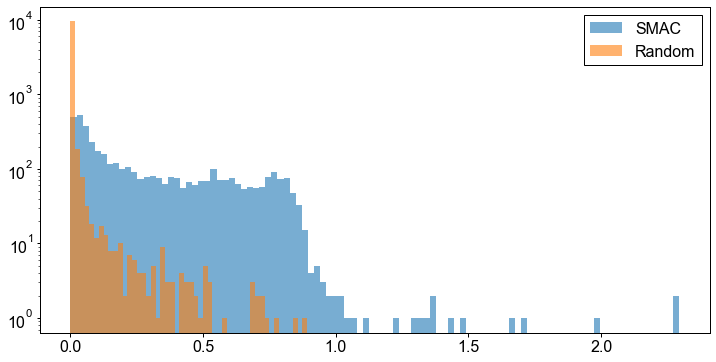

In [47]:

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(1, 1, 1)
idx = cand_all.loc[:, "search_type"] == "SMAC"
ax.hist(cand_all.loc[idx, "ei"], bins = 100, alpha = 0.6, label = "SMAC")

idx = cand_all.loc[:, "search_type"] == "Random"
ax.hist(cand_all.loc[idx, "ei"], bins = 50, alpha = 0.6, label = "Random")
plt.yscale("log")
plt.legend()
plt.savefig("out/cand_random.png")

In [49]:
hogege = []
for key,row in cand_all.loc[idx,comp].head(5).iterrows():
    temp = [str(i)+':'+str(round(v,1)) for i,v in row[row>0].sort_values(ascending=False).iteritems()]
    hogege.append(temp)
    
hogege = [' '.join(x) for x in hogege]
hogege

['Tb:100.0',
 'Pr:100.0',
 'In:50.8 Pd:35.1 Ru:14.1',
 'In:47.7 Sb:30.0 Pt:22.3',
 'Cl:59.0 Pd:24.0 Cu:16.9']

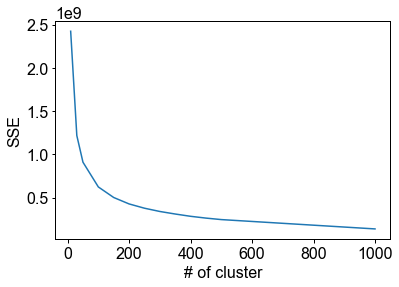

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = {}
k_s = [10, 30, 50, 100, 150,  200, 250, 300, 350,  400, 450,  500, 1000 ]

for k in k_s:
    kmeans = KMeans(n_clusters =k).fit(cand.loc[:, "Li":"Contact time, s"])
    cand["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("# of cluster")
plt.ylabel("SSE")
plt.savefig("out/sse.png")

For n_clusters = 80 The average silhouette_score is : 0.22565558955657417


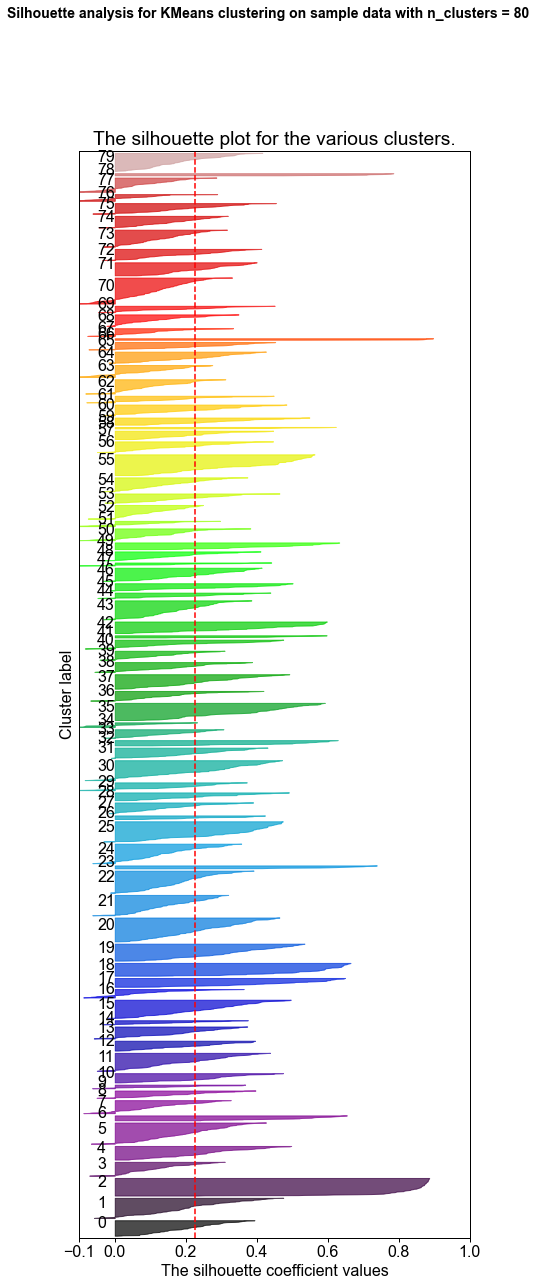

In [26]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

range_n_clusters = [80]
X = np.array(cand.loc[:, "Li":"Contact time, s"])
y = model.predict(cand.loc[:, "1_electronegativity":"Contact time, s"])

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(7, 20)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.savefig(f"out/silhouette_n_clusters_{i}.png")

In [27]:
print('avg', silhouette_avg)
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    val_max = np.max(ith_cluster_silhouette_values)
    if val_max >= silhouette_avg:
        print('O ', i, val_max)
    else:
        print('X ', i, val_max)

avg 0.22565558955657417
O  0 0.3933941343396973
O  1 0.47440560431920475
O  2 0.8853458024805649
O  3 0.30955010585637344
O  4 0.49681304489243683
O  5 0.4257160232121998
O  6 0.6534470383439691
O  7 0.3264875688870384
O  8 0.39614182691736666
O  9 0.3669973133362354
O  10 0.47361509274731234
O  11 0.43724787481013266
O  12 0.39481023585581826
O  13 0.3728487748382957
O  14 0.3745876418738052
O  15 0.4954730973127437
O  16 0.36296453886511987
O  17 0.6483261489796746
O  18 0.6638196194165576
O  19 0.5341533136531917
O  20 0.4636201623728548
O  21 0.31935403231674475
O  22 0.3908304543228487
O  23 0.737817867401878
O  24 0.3559724881823132
O  25 0.4732257897437095
O  26 0.4228345327274129
O  27 0.38954769353585245
O  28 0.4903455484035408
O  29 0.3716936136315859
O  30 0.4708563178509728
O  31 0.4301690711613886
O  32 0.6277941368348053
O  33 0.30613785197099286
O  34 0.2314621566413249
O  35 0.5913494456617453
O  36 0.41859501884476413
O  37 0.49148464112105467
O  38 0.3865464494615822

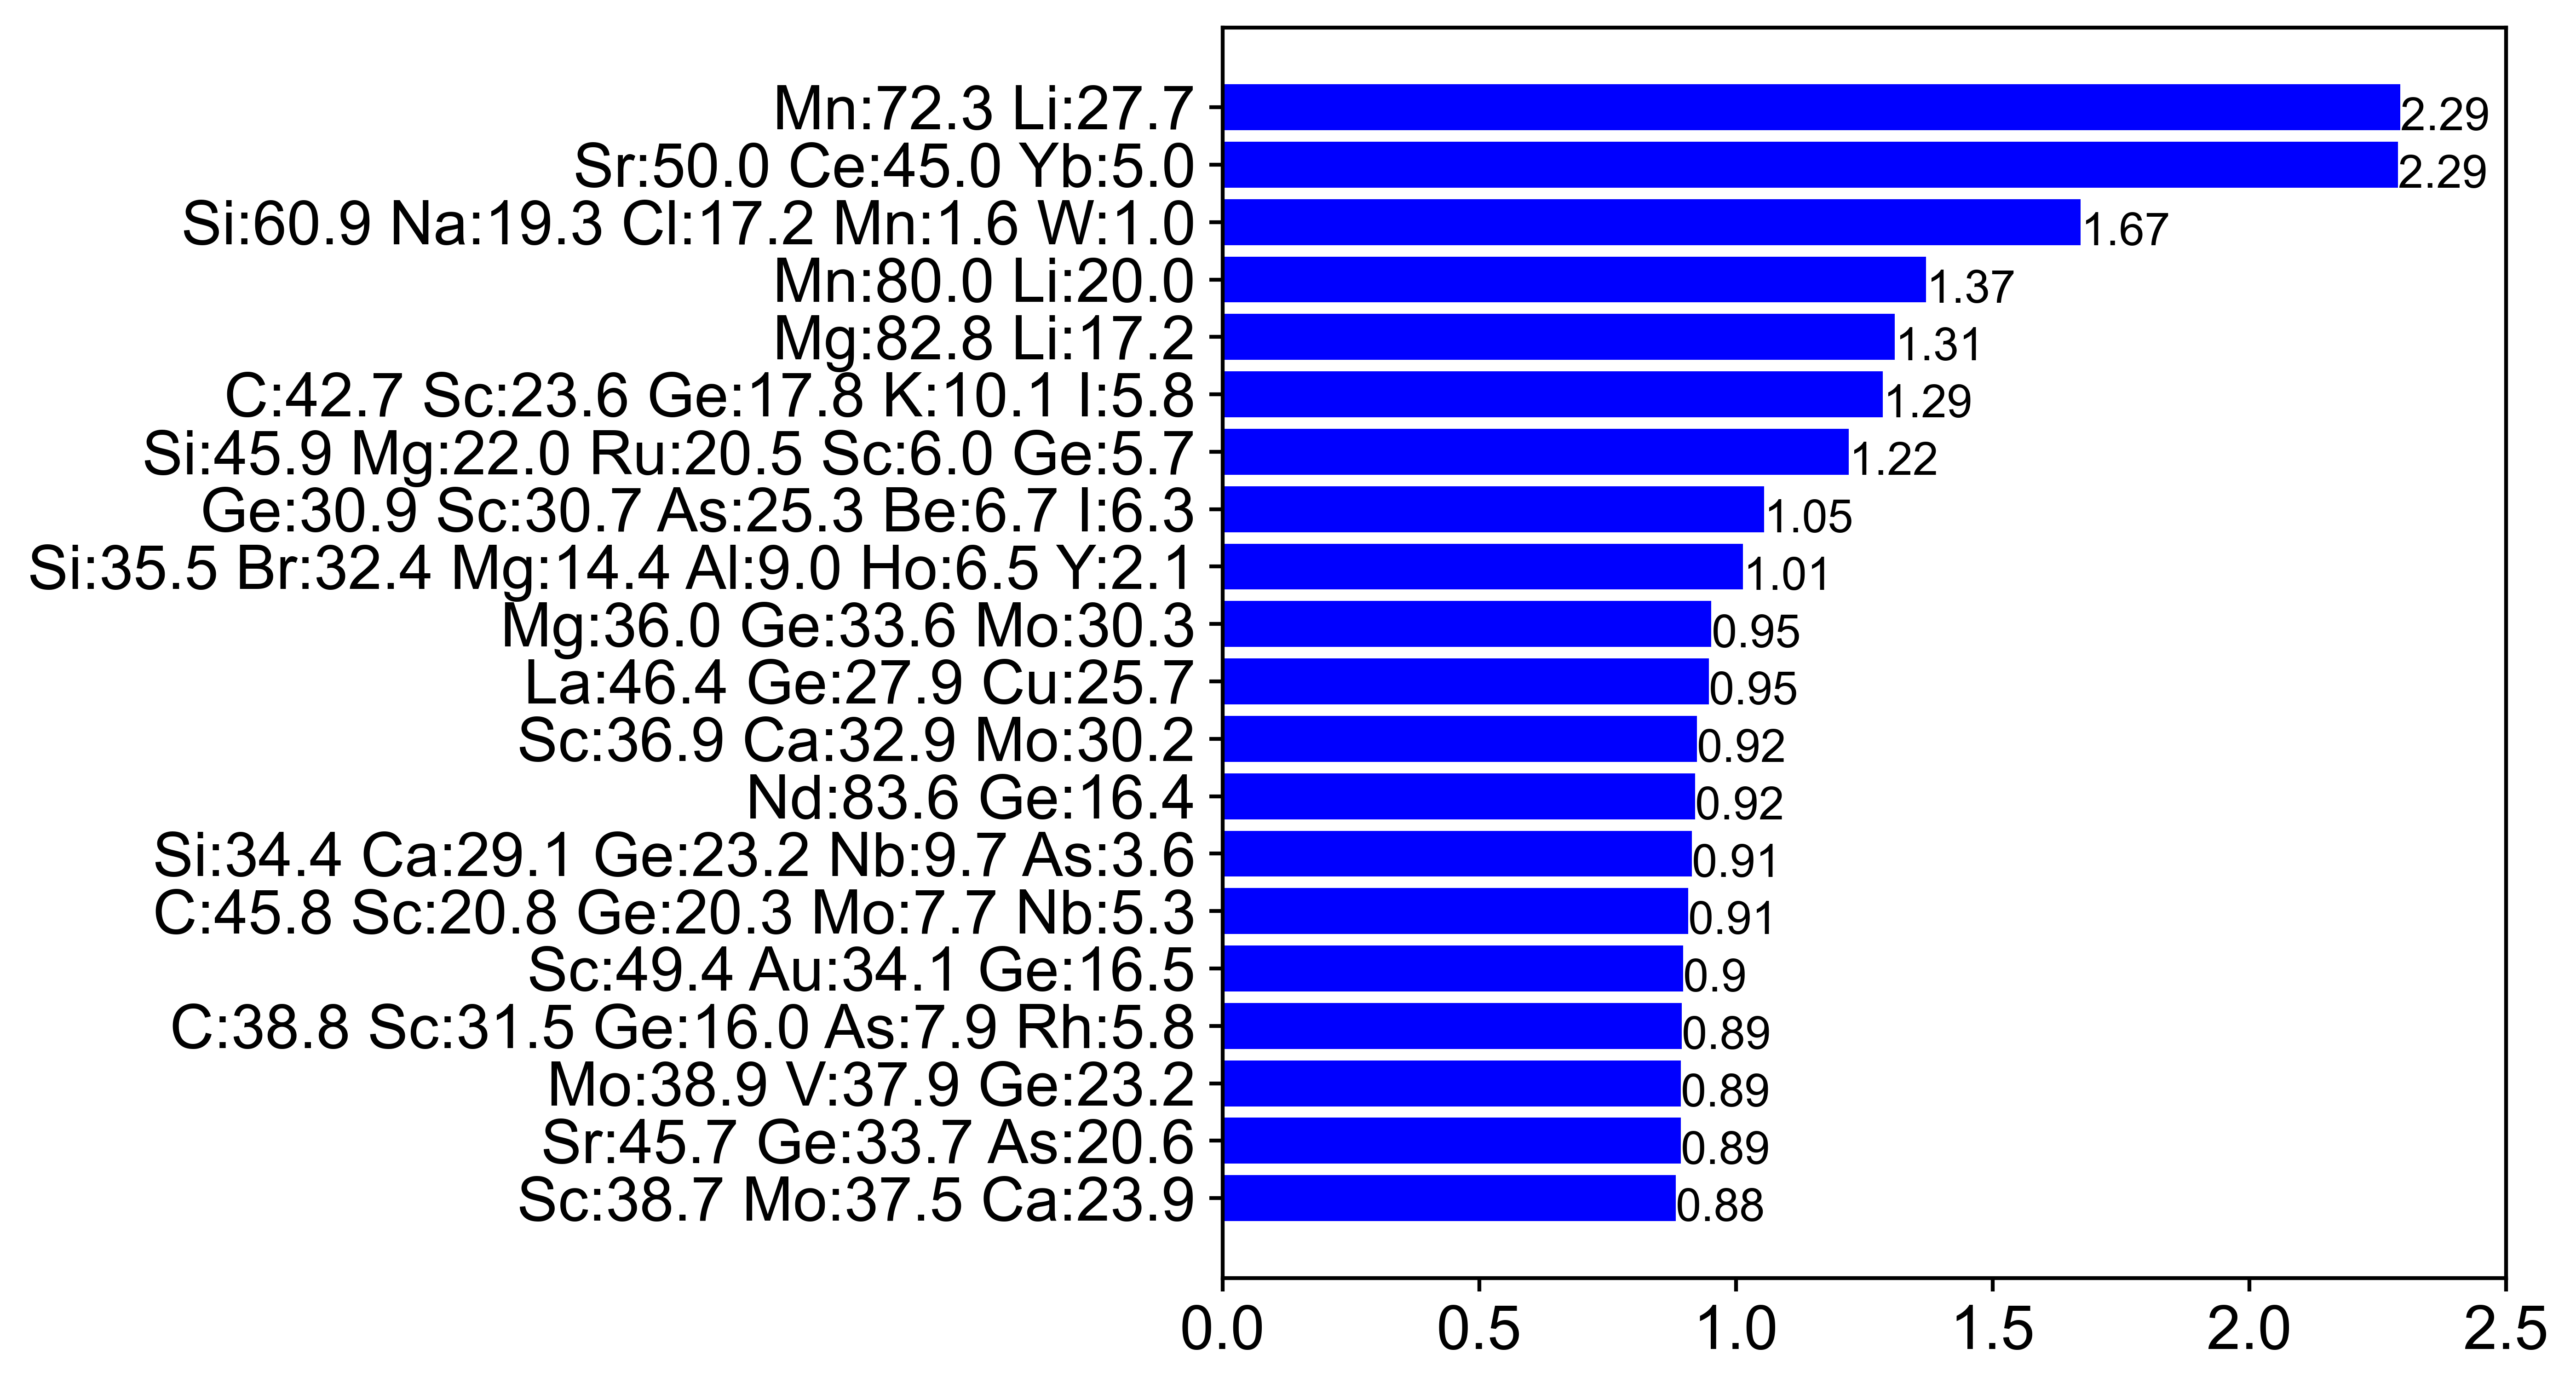

In [28]:
cand = pd.read_csv("out/cand.csv").drop("Unnamed: 0", axis = 1)
comp = cand.loc[:, "Li":"Bi"].columns
cand = cand.iloc[:, :-2]

from sklearn.cluster import KMeans
feat = feat.loc[:,"1_electronegativity":"Contact time, s"]
model = opt_ETR(n_estimators = 500, n_jobs = -1)
k = KMeans(n_clusters=80, random_state=1126)
cluster = k.fit_predict(cand.iloc[:,:-1])
cluster = pd.Series(cluster, index=cand.index, name='cluster') 
cand = pd.concat([cand,cluster], axis=1)
model.fit(feat, target)
pred_y = model.predict(cand.loc[:,"1_electronegativity":"Contact time, s"])
pred_y = pd.Series(pred_y, index = cand.index, name = 'pred_y')
cand = pd.concat([cand,pred_y], axis = 1)
#choose point which has most better ei value in each cluster
clus_high = cand.sort_values(by=['cluster','ei']).drop_duplicates(subset=['cluster'],keep='last')
clus_high = clus_high.sort_values(by='ei', ascending=False)

hogege = []
for key,row in clus_high.loc [:,comp].iterrows():
    temp = [str(i)+':'+str(round(v,1)) for i,v in row[row>0].sort_values(ascending=False).iteritems()]
    hogege.append(temp)
    
hogege = [' '.join(x) for x in hogege]

w = 0.4
hoge = clus_high.iloc[:20]
x = np.arange(hoge.shape[0])
pred_y = list(clus_high['pred_y'])
    
                
extra = []
for y in x:
    extra.append(y)
    
ytick = []
for n in range(20):
    ytick.append(hogege[n])
    
plt.figure(figsize=(6,6), dpi=600)
plt.barh(x,hoge['ei'][::-1],label='EI', color = 'blue')
for n,i in enumerate(x[::-1]):
    plt.text(clus_high['ei'].iloc[n],i-0.4,str(round(clus_high['ei'].iloc[n],2)),fontsize=12)
temp =clus_high.loc[:,"Temperature, K":"ei"]
temp.index = hogege

plt.xlim([0,2.5])
plt.yticks(x[::-1],ytick)
#temp =clus_high.loc[:,"Temperature, K":"ei"]
#temp.index = hogege
#temp.to_csv("Table_3.csv")
plt.savefig('ETR_sigm00a = 0.2.png', dpi = 600, bbox_inches = 'tight')

In [23]:
clus_high.index = np.arange(len(clus_high))

In [24]:
prep_list = pd.Series(index = np.arange(len(clus_high)))
prom_list = pd.Series(index = np.arange(len(clus_high)))
for s in preparations:
    idx =clus_high[s] >0
    prep_list[idx] = s
    prep_list
for s in promoters:
    idx =clus_high[s] >0
    prom_list[idx] = s
    prom_list

<ipython-input-24-d2b0bf25e9e9>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prep_list = pd.Series(index = np.arange(len(clus_high)))
<ipython-input-24-d2b0bf25e9e9>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prom_list = pd.Series(index = np.arange(len(clus_high)))


In [25]:
outdata =pd.concat([pd.DataFrame(hogege), pd.DataFrame(prep_list), pd.DataFrame(prom_list), 
                                     pd.DataFrame(np.array(clus_high[cond])),pd.DataFrame(np.array(clus_high["ei"]))], axis = 1)

In [147]:
outdata.to_csv("out/clus_high.csv")

In [148]:
clus_high["Impregnation"] >0

0     False
1     False
2     False
3     False
4     False
      ...  
85    False
86    False
87     True
88    False
89    False
Name: Impregnation, Length: 90, dtype: bool